In [1]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
from data_agent import DataAgent, TacProcess
import numpy as np
from data_util import *
import tensorflow as tf
from sklearn_model_hyper import *
import pandas as pd
from stock_agent import *


In [2]:
def get_y_data(ohlc, shift = -1):
    combined_data = ohlc
    #combined_data['return'] = np.log(combined_data / combined_data.shift(1))
    returns = (ohlc / ohlc.shift(shift))
    combined_data['return'] = returns
    combined_data['direction'] = np.where(combined_data['return'] < 1, 1, 0)
    #print(combined_data)
    #combined_data.dropna(inplace=True)
    #print(combined_data[20:40])
    return combined_data['direction'].to_numpy()

def split(x, y, split, shuffle=False):
    trainX, valX, trainY, valY = train_test_split(np.array(x), np.array(y), test_size=split, shuffle=shuffle)
    print("Completed: {} {} {} {}".format(trainX.shape, trainY.shape, valX.shape, valY.shape))
    return trainX, trainY, valX, valY


def get_full_database(resample, raw_dir, base_dir = "data/"):

    full_data = base_dir + raw_dir + "/"
    data_gen = DataGenerator(random = False, base_dir = full_data)
    data_gen.rewind()
    data_count = (data_gen.steps - 100)
    #data_count = 200000

    final_x = []

    closed_prices = []

    on_new_data = lambda x: final_x.append(x)
    on_closed_price = lambda price: closed_prices.append(price)
    
    agent = DataAgent(
        resample = resample,
        on_new_data = on_new_data,
        on_closed_price = on_closed_price
    )

    print("Processing {}".format(raw_dir))

    for i in tqdm(range(data_count)):
        agent.on_new_raw_data(data_gen.next())


    closes = pd.DataFrame(closed_prices, columns = ['Close'])

    final_y = get_y_data(closes, -1)
    
    #print(agent.ohlc)
    
    return final_x, closed_prices

In [3]:
#data_gen = DataGenerator(random=False, base_dir = "data/4jul21/")

#data_gen = DataGenerator(random=False, base_dir = "data/backtest/")

#data_gen = DataGenerator(random=False, base_dir = "data/btcusd/")

data_gen.rewind()


2


In [63]:

x, y, closed_prices = get_full_database('2Min', "4jul21", base_dir = "data/")

len(x)

Resample 2Min - TecAn ( windows 20, windows_limit 100 )
Processing 4jul21


<ipython-input-2-8a68d73f34cd>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/301794 [00:00<?, ?it/s]

301

In [64]:
back = BackTest(value = 100, verbose = False)
for idx in range(len(x)):
    yy = y[idx]
    price = closed_prices[idx]
    #print(f'{idx} {yy} {price}')
    back.on_state(0, price)
    if(yy == 1):
        back.request_buy(price)
    else:
        back.request_sell(price)


In [65]:
back.report()

100
111.09823730087544
11.0982%


In [66]:
from joblib import dump, load

models = [
    load('model/RandomForestClassifier_f1_score'),
    load('model/RandomForestClassifier_accuracy_score'),
    load('model/CatBoostClassifier'),
    load('model/RandomForestClassifier_precision_score'),
]

print(f"{len(models)}")

4


In [67]:
for model in models:
    print(model)
    back = BackTest(value = 10, verbose = False)
    for idx in range(len(x)):
        xx = [x[idx]]
        yy = model.predict(xx)[0]
        price = closed_prices[idx]
        #print(f'{idx} {yy} {price}')
        back.on_state(0, price)
        if(yy == 1):
            back.request_buy(price)
        else:
            back.request_sell(price)
    back.report()


RandomForestClassifier(criterion='entropy', max_depth=5, max_features=7,
                       n_estimators=30)
100
89.742998650021
-10.257%
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=100,
                                        n_estimators=30, random_state=42))])
100
89.94044134624495
-10.0596%
100
89.80248102209023
-10.1975%
RandomForestClassifier(max_depth=8, max_features=6)
100
89.71725862472364
-10.2827%


In [8]:
data_count = data_gen.steps
#data_count = 200000 
data_gen.rewind()

raw_data = []

for i in tqdm(range(data_count)):
    raw_data.append(data_gen.next())

<ipython-input-8-5fbf08f74a14>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/301894 [00:00<?, ?it/s]

In [9]:
def process_model(model, resample):
    back = BackTest(value = 100, verbose = True)

    request_sell = lambda price: back.request_sell(price)
    request_buy = lambda price: back.request_buy(price)
    on_state = lambda timestamp, price: back.on_state(timestamp, price)

    stock = StockAgent(model = model,
                    request_sell = request_sell,
                    request_buy = request_buy,
                    on_state = on_state
                      )


    data_gen.rewind()
    back.reset()

    on_new_data = lambda x: print(x)
    on_new_data = lambda x: stock.on_x(x)

    on_state = lambda timestamp, price, bid, ask: print("{} {} {} {}".format(timestamp, price, bid[-1], ask[-1]))
    on_state = lambda timestamp, price, bid, ask: stock.on_new_state(timestamp, price, bid, ask)


    agent = DataAgent(
        resample = resample,
        on_state = on_state,
        on_new_data = on_new_data
    )

    on_new_data_count = 0

    for raw in tqdm(raw_data):
        agent.on_new_raw_data(raw)

    if (back.bought):
        stock.sell()

    (agent.ohlc).plot(figsize=(20, 12))
        
    return back

In [10]:
class ModelTest():
    
    def __init__(self,
                 resample = '2Min'
                 ):
        self.index = 0
        
    def predict(self, x):
        yy = y[self.index]
        self.index += 1
        return [yy]

Resample 2Min - TecAn ( windows 20, windows_limit 100 )


<ipython-input-9-4a733010ee1d>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for raw in tqdm(raw_data):


  0%|          | 0/301894 [00:00<?, ?it/s]

2021-07-04 22:50:12 Buy (35393.15): ask: 35393.15
2021-07-04 22:54:12 Sell (35414.75) 21.599999999998545 total: 100.06102875838968
2021-07-04 23:02:01 Buy (35287.67): ask: 35287.67
2021-07-04 23:06:06 Sell (35338.63) 50.95999999999913 total: 100.20544180691343
2021-07-04 23:10:02 Buy (35300.0): ask: 35300.0
2021-07-04 23:20:02 Sell (35434.0) 134.0 total: 100.58504520634685
2021-07-04 23:24:06 Buy (35387.81): ask: 35387.81
2021-07-04 23:32:12 Sell (35451.63) 63.81999999999971 total: 100.76538979393224
2021-07-04 23:44:00 Buy (35323.22): ask: 35323.22
2021-07-04 23:48:09 Sell (35392.23) 69.01000000000204 total: 100.9607570339517
2021-07-04 23:50:17 Buy (35321.66): ask: 35321.66
2021-07-04 23:52:19 Sell (35333.41) 11.75 total: 100.9940227411693
2021-07-04 23:56:11 Buy (35291.95): ask: 35291.95
2021-07-04 23:58:17 Sell (35314.02) 22.06999999999971 total: 101.05655824855837
2021-07-05 00:04:04 Buy (34934.34): ask: 34934.34
2021-07-05 00:06:05 Sell (35015.65) 81.31000000000495 total: 101.289

2021-07-05 07:04:07 Buy (34212.14): ask: 34212.14
2021-07-05 07:08:13 Sell (34256.74) 44.599999999998545 total: 109.08120542388069
2021-07-05 07:16:09 Buy (34162.67): ask: 34162.67
2021-07-05 07:18:12 Sell (34213.07) 50.400000000001455 total: 109.2287348763503
2021-07-05 07:22:06 Buy (34149.71): ask: 34149.71
2021-07-05 07:24:07 Sell (34150.38) 0.6699999999982538 total: 109.23069682566114
2021-07-05 07:26:03 Buy (34100.05): ask: 34100.05
2021-07-05 07:34:08 Sell (34226.54) 126.48999999999796 total: 109.60163469818625
2021-07-05 07:36:01 Buy (34184.99): ask: 34184.99
2021-07-05 07:42:07 Sell (34223.44) 38.450000000004366 total: 109.7141109633541
2021-07-05 07:46:17 Buy (34154.42): ask: 34154.42
2021-07-05 07:48:08 Sell (34206.44) 52.020000000004075 total: 109.86641921511186
2021-07-05 07:50:07 Buy (34199.66): ask: 34199.66
2021-07-05 08:02:01 Sell (34270.91) 71.25 total: 110.07475461961587
2021-07-05 08:04:12 Buy (34210.85): ask: 34210.85
2021-07-05 08:10:07 Sell (34281.05) 70.200000000

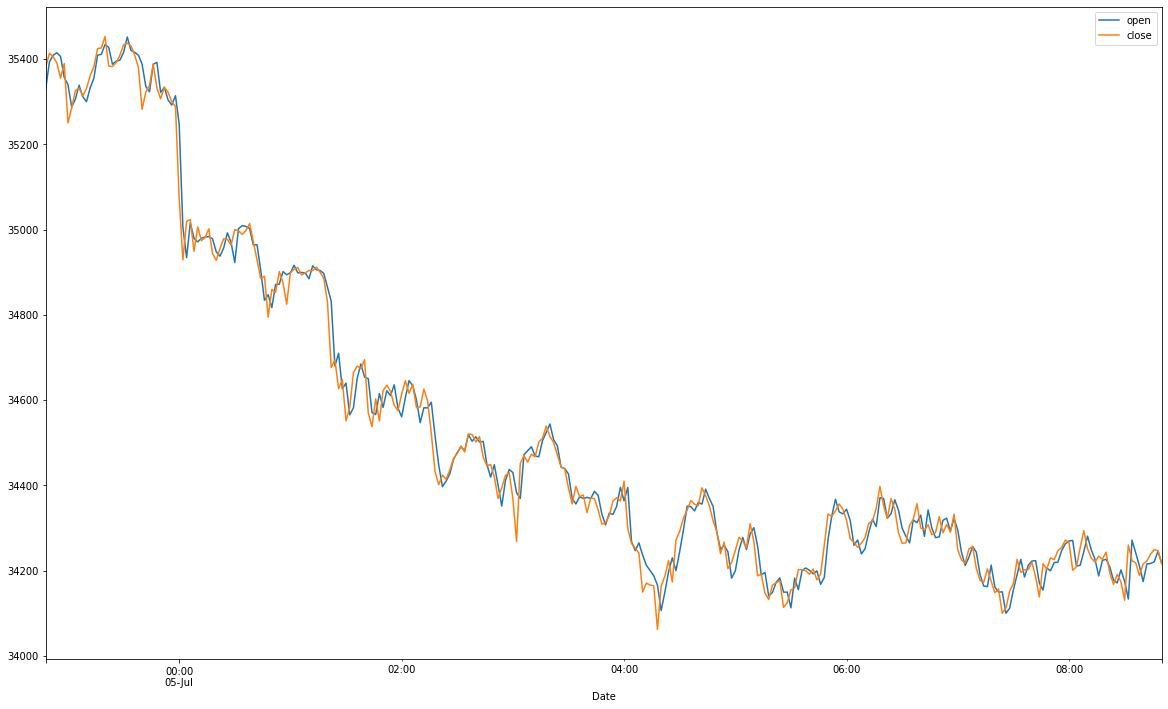

In [11]:
model = ModelTest()
backProc = process_model(model, '2Min')

In [12]:
backProc.report()

100
111.09823730087544
11.0982%
